# **<center>Action Recognition from Videos using Recurrent Neural Networks</center>**

The objective of this exercise is to classify the type of action being executed in videos.

The UCF101 dataset will be used. Four classes: Basketball, Diving, Golf Swing, Skiing

* 140 videos for training. Approximately 40 videos for each class. Each video has 40 frames.

* 400 videos for testing. Approximately 100 videos for each class. Each video has 40 frames.





# **<center>Network Architecture</center>**



Each frame is passed to a CNN encoder. The result is flattened and passed to the RNN network. We take the last output of the sequence to produce the final classification result

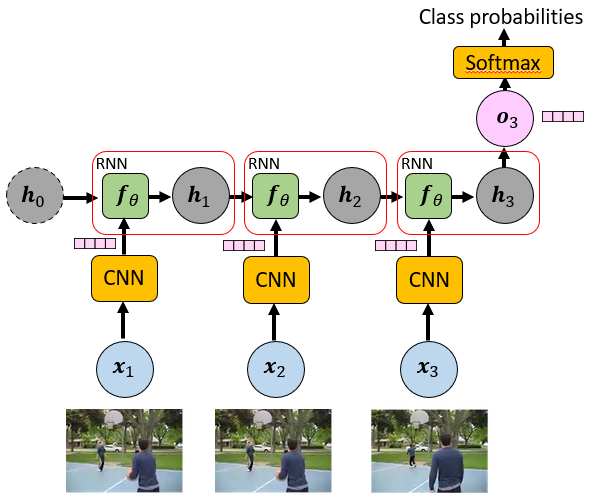

Each frame is passed to a pre-trained, frozen VGG16 encoder. Global Average Pooling (GAP) is applied to the resulting sequence of feature maps, producing a sequence of feature vectors. The sequence is passed to a many-to-one LSTM, followed by a dense network with softmax activation for the final class probabilities

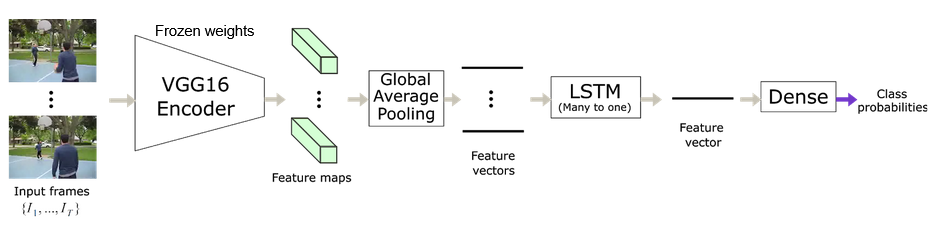

## **<center>Global average pooling (GAP)</center>**

The encoder output is passed to a GAP layer. It obtains the spatial global average value for each channel in the feature map.

GAP is **independently applied** to **each feature map** in the sequence.

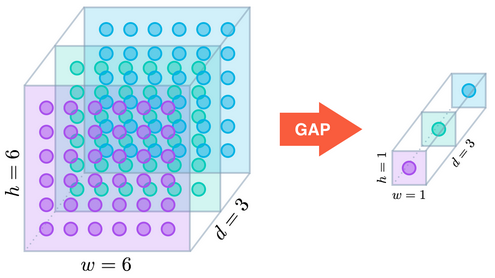

## **<center>VGG Encoder</center>**

The VGG16 encoder is used with ImageNet pre-trained weights.

The encoder is **indepentently** applied to **each frame** in the input video.

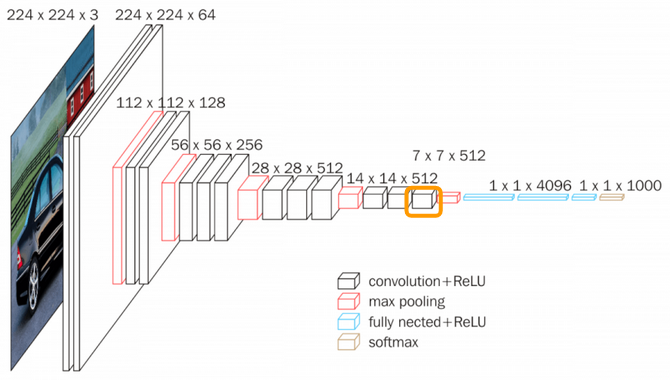

## **<center>Many-to-one LSTM (N-to-1)</center>**

The sequence of feature vectors is passed to a LSTM. We only take the latest element in the resulting sequence. Then we apply a Dense layer with softmax activation function for the final class probabilities

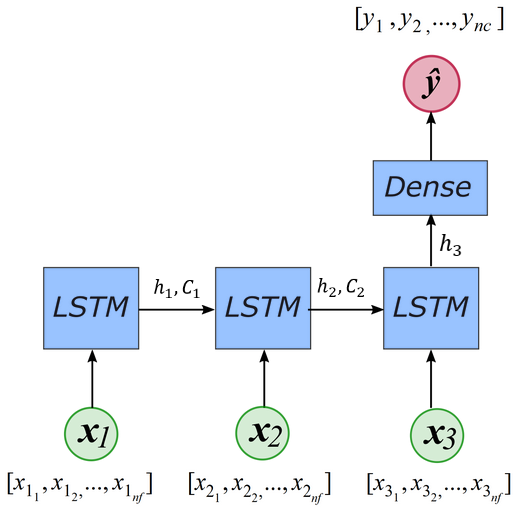

In [ ]:
!pip install scikit-video
!pip install icecream
!pip install -q git+https://github.com/tensorflow/docs
!pip install imageio

  Preparing metadata (setup.py) ... done


In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.layers import GlobalAveragePooling2D
from keras import Model


import skvideo.io
import skvideo.datasets
import glob

import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Input
from keras.models import Model
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from keras import utils
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import time
import pandas as pd

import imageio
from tensorflow_docs.vis import embed
import cv2
import os
%matplotlib inline
import pathlib
# fix random seed for reproducibility
np.random.seed(7)

import tensorflow
tensorflow.random.set_seed(3)

t0 = time.time()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **<center>Dataset loading and preprocessing</center>**

We will be using the UCF101 action recognition dataset. 4 classes were selected: Basketball, Diving, GolfSwing, Skiing

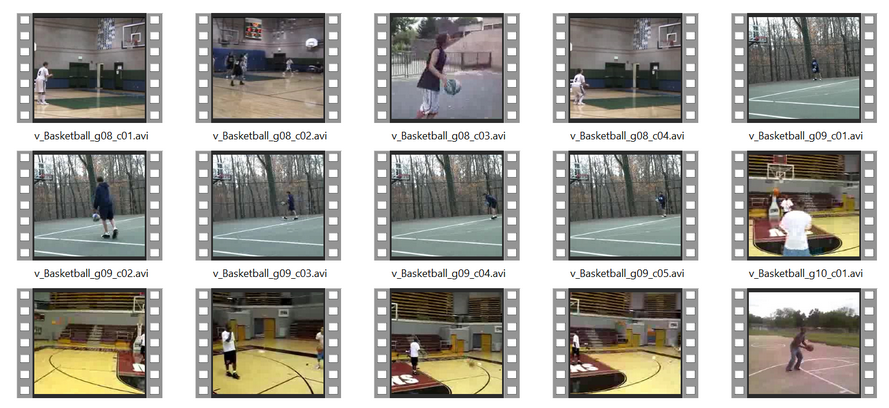

## **<center>Download the videos</center>**



In [ ]:
t0=time.time()
os.getcwd()

path = '/content/gdrive/My Drive/RNN_exercise'
pathlib.Path(path).mkdir(parents=True, exist_ok=True)
os.chdir(path)
# Download the videos
!gdown --i 1_qRKzrIVJ8vHVpM9lMuvrcjzUzp_9NuY

!unzip -n /content/gdrive/My\ Drive/RNN_exercise/Videos.zip -d .

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_qRKzrIVJ8vHVpM9lMuvrcjzUzp_9NuY
To: /content/gdrive/My Drive/RNN_exercise/Videos.zip
100% 208M/208M [00:00<00:00, 233MB/s]
Archive:  /content/gdrive/My Drive/RNN_exercise/Videos.zip


In [ ]:
!ls
!ls Videos/Testing
!ls Videos/Training


animation.gif  pretrained_features.npz	Videos	Videos.zip
Basketball  Diving  GolfSwing  Skiing
Basketball  Diving  GolfSwing  Skiing


## **<center>Prepare the dataset</center>**
* Train test split
* Define the frame number = 40
* Convert labels to one-hot encoding



In [ ]:

# This function assigns the corresponding class labels to each sample
def dataset_build(data_path, classes, set_):
  set_file_count=len(glob.glob(data_path+set_+'/**/*.avi',recursive=True))
  print(set_+" file count:",set_file_count)
  X_filenames=[]
  Y=np.zeros(set_file_count)
  sample_id=0
  for clss_name,clss_idx in zip(classes,range(len(classes))):
    clss_file_list=glob.glob(data_path+set_+'/'+clss_name+'/*.avi')
    X_filenames+=clss_file_list
    print("debug: sample_id={}, len(clss_file_list)={}".format(sample_id,clss_file_list))
    Y[sample_id:sample_id+len(clss_file_list)]=clss_idx # Assing labels to samples from each class
    sample_id+=len(clss_file_list)
  return X_filenames, Y

data_path='Videos/'
classes=['Basketball','Diving','GolfSwing','Skiing']
t_len, feature_len, class_n = 40, 512, len(classes)
X_filenames_train,Y_train=dataset_build(data_path, classes, set_='Testing')
X_filenames_test,Y_test=dataset_build(data_path, classes, set_='Training')

print("Train class unique values",np.unique(Y_train,return_counts=True))
print("Test class unique values",np.unique(Y_test,return_counts=True))
print("Classes:",classes)

# Set labels to one-hot
Y_train=utils.to_categorical(Y_train)
Y_test=utils.to_categorical(Y_test)

Testing file count: 159
debug: sample_id=0, len(clss_file_list)=['Videos/Testing/Basketball/v_Basketball_g01_c01.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c02.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c04.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c03.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c06.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c05.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c02.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c01.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c03.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c07.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c05.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c04.avi', 'Videos/Testing/Basketball/v_Basketball_g03_c01.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c06.avi', 'Videos/Testing/Basketball/v_Basketball_g03_c02.avi', 'Videos/Testing/Basketball/v_Basketball_g03_c03.avi', 'Videos/Testing/Basketball/v_Basketball_g03_c04.avi', 'Videos/Testing/B

# **<center>Define the pre-trained model and extract features</center>**


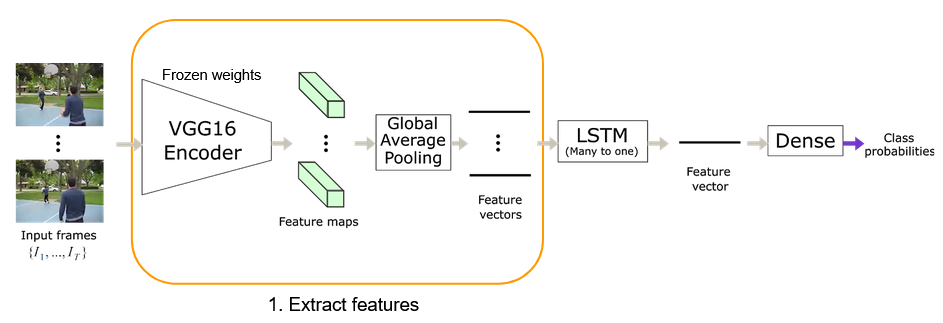

## Specify the pre-trained encoder architecture

In [ ]:
def get_model():
    # YOU: Create the VGG16 encoder with imagenet pre-trained weights
    # HINT: Drop the softmax classification layer and use GlobalAveragePooling2D instead.
    model_base = VGG16(include_top=False, weights='imagenet', classifier_activation=None)
    output = model_base.output
    # adding pooling layer
    output = GlobalAveragePooling2D()(output)
    model = Model(model_base.input, output)
    # freezing
    for layer in model_base.layers:
      layer.trainable = False
    return model

def extract_features(video_path, model, num_frames=40):

    '''
    1. Loads a video as videogen
    2. Extracts features from VGG16 CNN encoder model for each frame in vgg16_feature

    Arguments

    video_path: path to the video file.
    model: VGG16 CNN encoder model.
    num_frames: number of frames in the video. Each video has 40 frames.

    Return value

    Returned value is of shape (t_len, feature_len)
    '''
    # Load the video
    if video_path is None:
        video_path = skvideo.datasets.bigbuckbunny()
    videogen = skvideo.io.vreader(video_path)
    vgg16_feature = []

    # Extract features for each frame
    for i in range(num_frames):
        # print(frame.shape)
        frame_crop = next(videogen)[:224,:224]

        img_data = np.expand_dims(frame_crop, axis=0)
        img_data = preprocess_input(img_data) # Covert from RGB to BGR. Then subtract ImageNet mean value

        vgg16_feature.append(model.predict(img_data))

    return np.squeeze(np.array(vgg16_feature))

In [ ]:
cnnModel = get_model()

## Extract features from the pre-trained model

In [ ]:
X_filenames_test[0]

'Videos/Training/Basketball/v_Basketball_g08_c03.avi'

In [ ]:
# Creates a function for extracting features for all videos training and testing
# Features extracted from CNN correspond to X_train and X_test variables

import pdb

def extract_features_from_set(cnnModel, X_filenames, X):
  # YOU: Extract features for each video filename
  # HINT: Use extract_features() function for each video.
  # X should be of shape (sample_id, t_len, feature_len)
  for i in range(len(X_filenames)):
    extracted_features = extract_features(X_filenames[i], cnnModel)
    X[i] = extracted_features
  return X

load_pretrained_features_flag = True
pretrained_features_filename = path + '/pretrained_features.npz'

if load_pretrained_features_flag == False:

  X_train = np.zeros((Y_train.shape[0],t_len,feature_len))
  X_test = np.zeros((Y_test.shape[0],t_len,feature_len))
  print("X train shape:{}, X test shape:{}".format(X_train.shape,X_test.shape))

  print("Before extract features execution time: ",time.time()-t0)

  X_train = extract_features_from_set(cnnModel, X_filenames_train, X_train)
  print("Train features extracted")
  print(X_train.shape,X_test.shape)
  X_test = extract_features_from_set(cnnModel, X_filenames_test, X_test)
  print("Test features extracted")

  # Save extracted CNN features
  np.savez(pretrained_features_filename, x_test = X_test, x_train = X_train)
else:
  # CNN feature extraction takes about 25 minutes.
  # After extracting for the first time, load the CNN features from file
  data = np.load(pretrained_features_filename)

  X_train = data['x_train']
  X_test = data['x_test']

print("X_train.shape={}, Y_train.shape={}".format(X_train.shape,Y_train.shape))
print("X_test.shape={}, Y_test.shape={}".format(X_test.shape,Y_test.shape))


X_train.shape=(159, 40, 512), Y_train.shape=(159, 4)
X_test.shape=(399, 40, 512), Y_test.shape=(399, 4)


# **<center>Define the trainable LSTM model</center>**
Define the LSTM block, and the final Dense layer with softmax. Also, define the training loss and optimizer

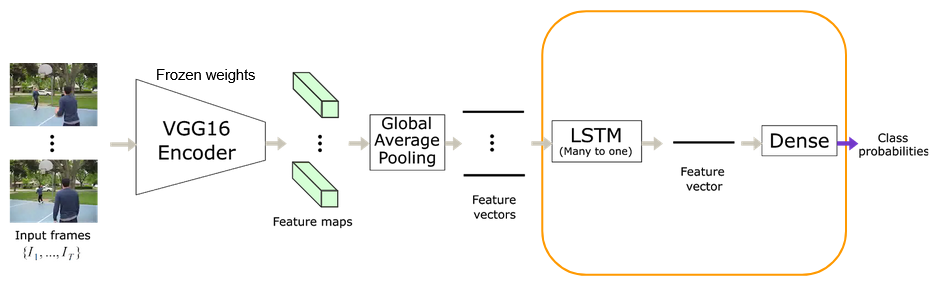

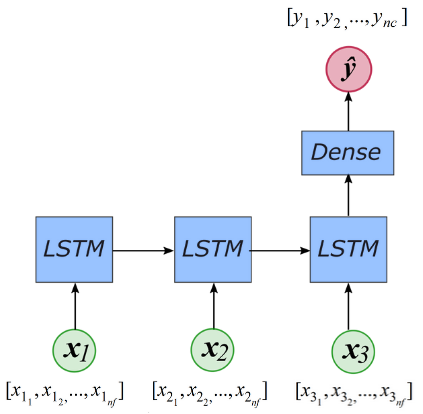

# **<center>Train & Evaluate the model</center>**

In [ ]:
def compute_metrics(true_labels, predicted_labels):
  accuracy = 100*accuracy_score(true_labels, predicted_labels)
  f1score = 100*f1_score(true_labels, predicted_labels, average=None)
  average_f1score = np.sum(f1score)/4
  return accuracy, f1score, average_f1score

internal_units = [50, 100, 200, 500]

In [ ]:
lstm = {
    50: {
        "Y_hat": None,
        "results": None,
        "model": None,
        "train_time": None
    },
    100: {
        "Y_hat": None,
        "results": None,
        "model": None,
        "train_time": None
    },
    200: {
        "Y_hat": None,
        "results": None,
        "model": None,
        "train_time": None
    },
    500: {
        "Y_hat": None,
        "results": None,
        "model": None,
        "train_time": None
    }
}

In [ ]:
for i in internal_units:
  print(f"\nLSTM WITH {i} INTERNAL UNITS")
  model = Sequential()
  model.add(LSTM(i,input_shape=(t_len, feature_len)))
  model.add(Dense(4, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  model.summary()

  early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001,
                            mode = 'max', patience = 15)

  t0 = time.time()
  model.fit(X_train, Y_train, epochs=1000, batch_size=50,
            validation_split = 0.1, verbose=2, callbacks=[early_stop])
  train_time = time.time() - t0

  Y_hat = model.predict(X_test)
  Y_hat = np.argmax(Y_hat, axis=-1)

  Y_hat = to_categorical(Y_hat, num_classes=4)

  results = compute_metrics(Y_test, Y_hat)

  lstm[i]["results"] = results
  lstm[i]["Y_hat"] = Y_hat
  lstm[i]["model"] = model
  lstm[i]["train_time"] = train_time


LSTM WITH 50 INTERNAL UNITS
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 50)                112600    
                                                                 
 dense_12 (Dense)            (None, 4)                 204       
                                                                 
Total params: 112804 (440.64 KB)
Trainable params: 112804 (440.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
3/3 - 4s - loss: 1.3357 - accuracy: 0.3916 - val_loss: 1.3483 - val_accuracy: 0.4375 - 4s/epoch - 1s/step
Epoch 2/1000
3/3 - 0s - loss: 0.8111 - accuracy: 0.6993 - val_loss: 1.1497 - val_accuracy: 0.6250 - 69ms/epoch - 23ms/step
Epoch 3/1000
3/3 - 0s - loss: 0.5091 - accuracy: 0.9231 - val_loss: 0.9292 - val_accuracy: 0.8125 - 63ms/epoch - 21ms/step
Epoch 4/1000
3/

In [ ]:
gru = {
    50: {
        "Y_hat": None,
        "results": None,
        "model": None,
        "train_time": None
    },
    100: {
        "Y_hat": None,
        "results": None,
        "model": None,
        "train_time": None
    },
    200: {
        "Y_hat": None,
        "results": None,
        "model": None,
        "train_time": None
    },
    500: {
        "Y_hat": None,
        "results": None,
        "model": None,
        "train_time": None
    }
}

In [ ]:
for i in internal_units:
  print(f"\nGRU WITH {i} INTERNAL UNITS")
  model = Sequential()
  model.add(GRU(i,input_shape=(t_len, feature_len)))
  model.add(Dense(4, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  model.summary()

  early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001,
                            mode = 'max', patience = 15)

  t0 = time.time()
  model.fit(X_train, Y_train, epochs=1000, batch_size=50,
            validation_split = 0.1, verbose=2, callbacks=[early_stop])
  train_time = time.time() - t0

  Y_hat = model.predict(X_test)
  Y_hat = np.argmax(Y_hat, axis=-1)

  Y_hat = to_categorical(Y_hat, num_classes=4)

  results = compute_metrics(Y_test, Y_hat)

  gru[i]["results"] = results
  gru[i]["Y_hat"] = Y_hat
  gru[i]["model"] = model
  gru[i]["train_time"] = train_time


GRU WITH 50 INTERNAL UNITS
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 50)                84600     
                                                                 
 dense_16 (Dense)            (None, 4)                 204       
                                                                 
Total params: 84804 (331.27 KB)
Trainable params: 84804 (331.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
3/3 - 2s - loss: 1.6925 - accuracy: 0.3776 - val_loss: 1.4940 - val_accuracy: 0.2500 - 2s/epoch - 779ms/step
Epoch 2/1000
3/3 - 0s - loss: 0.7929 - accuracy: 0.7413 - val_loss: 1.1808 - val_accuracy: 0.3750 - 66ms/epoch - 22ms/step
Epoch 3/1000
3/3 - 0s - loss: 0.4263 - accuracy: 0.9301 - val_loss: 0.8089 - val_accuracy: 0.7500 - 46ms/epoch - 15ms/step
Epoch 4/1000
3/

In [ ]:
deep_lstm = {
    50: {
        "Y_hat": None,
        "results": None,
        "model": None,
        "train_time": None
    },
    100: {
        "Y_hat": None,
        "results": None,
        "model": None,
        "train_time": None
    },
    200: {
        "Y_hat": None,
        "results": None,
        "model": None,
        "train_time": None
    },
    500: {
        "Y_hat": None,
        "results": None,
        "model": None,
        "train_time": None
    }
}

In [ ]:
for i in internal_units:
  print(f"\nDEEP LSTM WITH {i} INTERNAL UNITS")
  model = Sequential()
  model.add(LSTM(i,input_shape=(t_len, feature_len),return_sequences=True))
  model.add(LSTM(i,input_shape=(t_len, feature_len)))
  model.add(Dense(4, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  model.summary()

  early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001,
                            mode = 'max', patience = 15)

  t0 = time.time()
  model.fit(X_train, Y_train, epochs=1000, batch_size=50,
            validation_split = 0.1, verbose=2, callbacks=[early_stop])
  train_time = time.time() - t0

  Y_hat = model.predict(X_test)
  Y_hat = np.argmax(Y_hat, axis=-1)

  Y_hat = to_categorical(Y_hat, num_classes=4)

  results = compute_metrics(Y_test, Y_hat)

  deep_lstm[i]["results"] = results
  deep_lstm[i]["Y_hat"] = Y_hat
  deep_lstm[i]["model"] = model
  deep_lstm[i]["train_time"] = train_time


DEEP LSTM WITH 50 INTERNAL UNITS
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 40, 50)            112600    
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dense_20 (Dense)            (None, 4)                 204       
                                                                 
Total params: 133004 (519.55 KB)
Trainable params: 133004 (519.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
3/3 - 4s - loss: 1.2836 - accuracy: 0.4825 - val_loss: 1.2829 - val_accuracy: 0.5000 - 4s/epoch - 1s/step
Epoch 2/1000
3/3 - 0s - loss: 0.8190 - accuracy: 0.8811 - val_loss: 1.2273 - val_accuracy: 0.6250 - 59ms/epoch - 20ms/step
E

## **<center>Sample test predictions</center>**
Plot test predictions for the final model

(324, 224, 224, 3)
1/1 [==============================] - 0s 18ms/step
Classification result for video ID 25: Basketball



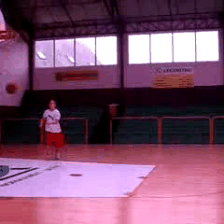

In [ ]:
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')


idx = np.random.randint(0, X_test.shape[0]) # Random ID from test set
sample_video = load_video(X_filenames_test[idx])

print(sample_video.shape)
sample_video = sample_video[:100]

# Make prediction on sample test video
prediction = lstm[200]["model"].predict(np.expand_dims(X_test[idx], axis=0))
prediction = np.squeeze(prediction)

print("Classification result for video ID {}: {}".format(idx, classes[prediction.argmax(axis=0)]))

# Display sample test video
to_gif(sample_video)

# **<center>Experiments</center>**

1. Use different LSTM internal units: 50, 100, 200, 500
2. Replace LSTM with GRU (count number of parameters)
3. Use a deep LSTM. Two stacked LSTM layers: The output of the first LSTM goes to the input of the second LSTM (Hint: The first LSTM should be configured as "N-to-N" using the parameter "return_sequences")

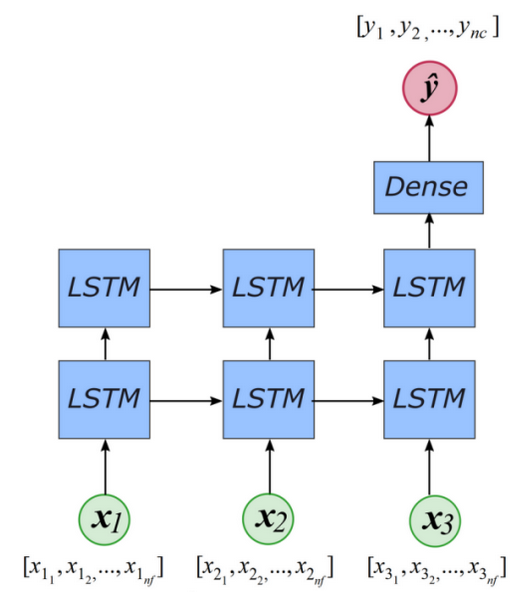

Note: the development of each experiment is above, at the training & model evaluation section.

In [ ]:
deep_lstm[500]["results"]

(93.734335839599,
 array([88.29787234, 94.49541284, 96.03960396, 95.78947368]),
 93.6555907072672)

# Report

Homework report: The report must contain:

1.    A link to the notebook with your code.
2.    A PDF file reporting your experiments, including the results in the form of the table, and discussing the results

Fill in your results in the following information in a table:


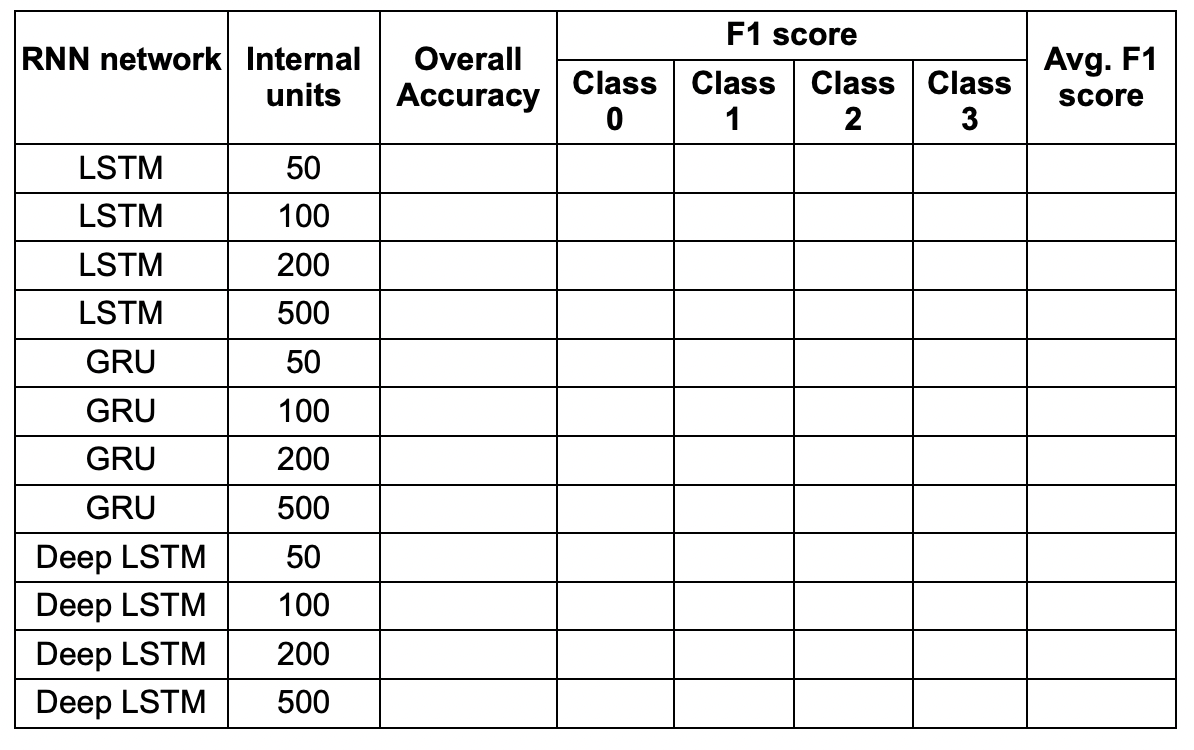